In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.4 MB/s eta 0:00:00


----------------------------------------------------------
Epoch [1/100], Train Loss (MSE): 0.0791, Test Loss (MSE): 0.3399
Epoch [2/100], Train Loss (MSE): 0.0716, Test Loss (MSE): 0.3160
Epoch [3/100], Train Loss (MSE): 0.0648, Test Loss (MSE): 0.2929
Epoch [4/100], Train Loss (MSE): 0.0586, Test Loss (MSE): 0.2704
Epoch [5/100], Train Loss (MSE): 0.0530, Test Loss (MSE): 0.2484
Epoch [6/100], Train Loss (MSE): 0.0480, Test Loss (MSE): 0.2270
Epoch [7/100], Train Loss (MSE): 0.0435, Test Loss (MSE): 0.2060
Epoch [8/100], Train Loss (MSE): 0.0397, Test Loss (MSE): 0.1856
Epoch [9/100], Train Loss (MSE): 0.0366, Test Loss (MSE): 0.1657
Epoch [10/100], Train Loss (MSE): 0.0341, Test Loss (MSE): 0.1467
Epoch [11/100], Train Loss (MSE): 0.0324, Test Loss (MSE): 0.1290
Epoch [12/100], Train Loss (MSE): 0.0315, Test Loss (MSE): 0.1130
Epoch [13/100], Train Loss (MSE): 0.0313, Test Loss (MSE): 0.0994
Epoch [14/100], Train Loss (MSE): 0.0316, Test Loss (MSE): 0.0887
Epoch [15/100], Train Loss

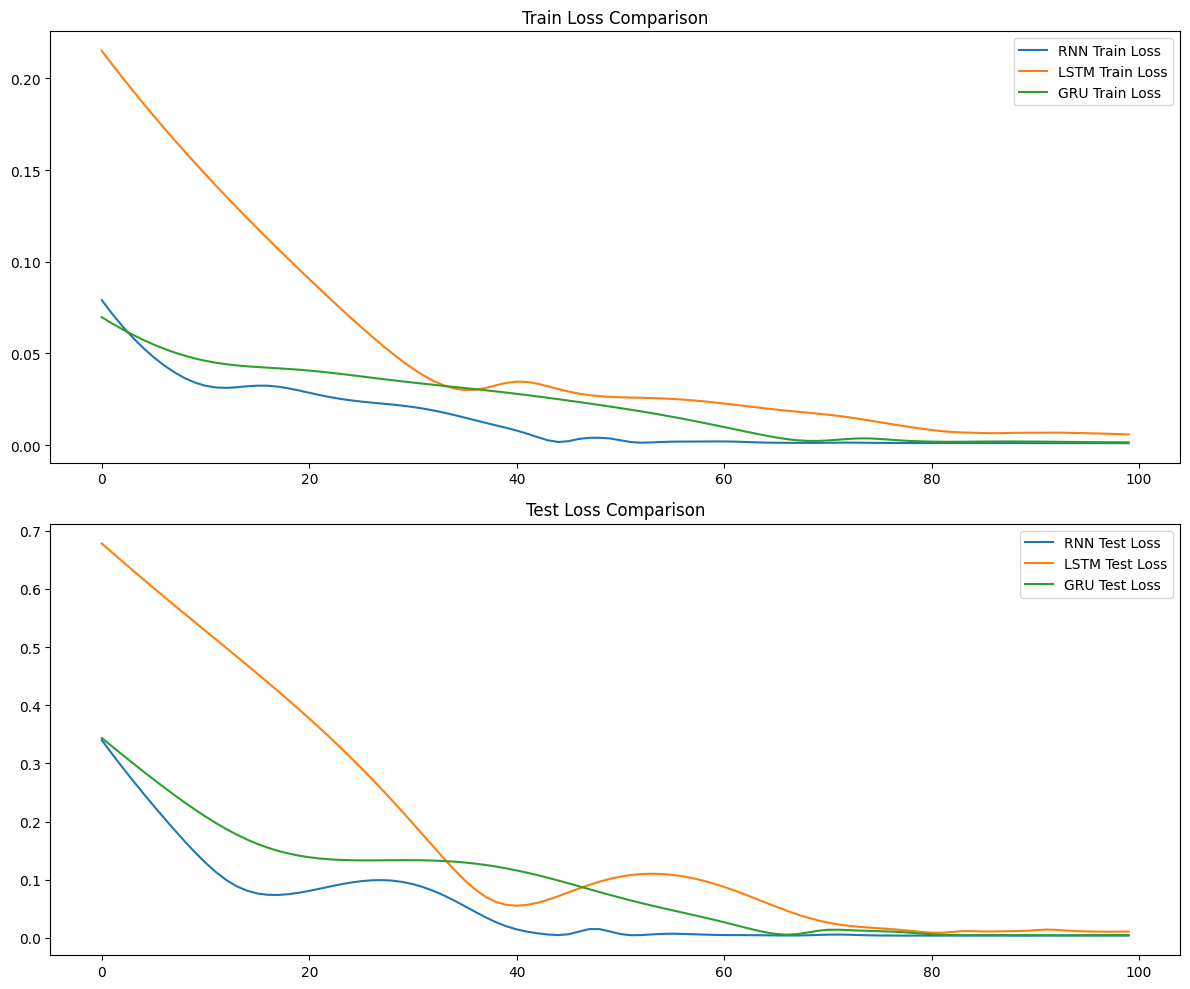

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

# 1. 데이터 로드 및 전처리
dataset = load_dataset("StockLlama/ETH-USD-2022-01-01_2024-08-30")
data = np.array(dataset['train']['label'], dtype=np.float32)

def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

data = normalize(data)

# 2. 슬라이딩 윈도우 생성
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return torch.tensor(sequences).unsqueeze(-1), torch.tensor(targets)

seq_length = 50
X, y = create_sequences(data, seq_length)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 3. 모델 정의 (RNN, LSTM, GRU 직접 구현)
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)
        return self.fc(out[:, -1, :])

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])

# 4. 학습 및 평가
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.0005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.MSELoss()  # MSELoss 사용
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    train_loss, test_loss = [], []
    print('----------------------------------------------------------')
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            test_pred = model(X_test).squeeze()
            val_loss = criterion(test_pred, y_test)

        train_loss.append(loss.item())
        test_loss.append(val_loss.item())

        # 매 epoch마다 MSE 출력
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss (MSE): {loss.item():.4f}, Test Loss (MSE): {val_loss.item():.4f}")

    return train_loss, test_loss

# 5. 실행 및 비교
hidden_dim = 64
rnn_model = RNNModel(1, hidden_dim)
lstm_model = LSTMModel(1, hidden_dim)
gru_model = GRUModel(1, hidden_dim)

rnn_loss = train_model(rnn_model, X_train, y_train, X_test, y_test)
lstm_loss = train_model(lstm_model, X_train, y_train, X_test, y_test)
gru_loss = train_model(gru_model, X_train, y_train, X_test, y_test)

# 6. 학습 곡선 비교
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(rnn_loss[0], label='RNN Train Loss')
axs[0].plot(lstm_loss[0], label='LSTM Train Loss')
axs[0].plot(gru_loss[0], label='GRU Train Loss')
axs[0].set_title("Train Loss Comparison")
axs[0].legend()

axs[1].plot(rnn_loss[1], label='RNN Test Loss')
axs[1].plot(lstm_loss[1], label='LSTM Test Loss')
axs[1].plot(gru_loss[1], label='GRU Test Loss')
axs[1].set_title("Test Loss Comparison")
axs[1].legend()

plt.tight_layout()
plt.show()


#데이터셋

ETH-USD-2022-01-01_2024_08_30 데이터셋은 이더리움의 시계열 가격 데이터이다.

매일의 주식 가격이 포함된 시계열 형태의 데이터로, input_ids는 길이가 256인 벡터다.

label은 다음날의 환율 데이터이다.

##데이터 전처리

데이터 전처리는 정규화와 슬라이딩 윈도우 기법을 적용하였다.

### 정규화

데이터를 [0, 1] 범위로 변환하였다. 정규화를 통해 학습을 더 효율적으로 만들어 주었다.

### 슬라이딩 윈도우
슬라이딩 윈도우를 통해 주어진 시계열 데이터를 짧은 시퀀스로 나누어 입력으로 주었다. 이를 통해 training data 양을 증가시켜 학습에 사용하였다.

손실 함수은 MSELoss, optimizer은 Adam을 사용하여 RNN, LSTM, GRU를 학습시켰다.


아래의 그래프는 처음에 epoch=50, lr=0.001로 주었을 때의 결과이다.

RNN의 성능이 제일 잘 나온 것을 확인할 수 있다.

RNN은 장기의존성을 처리하는 데 어려움이 있어 LSTM이 나왔는데 결과는 아래와 같이 RNN 성능이 가장 좋게 나와 그 이유를 생각해보았다.



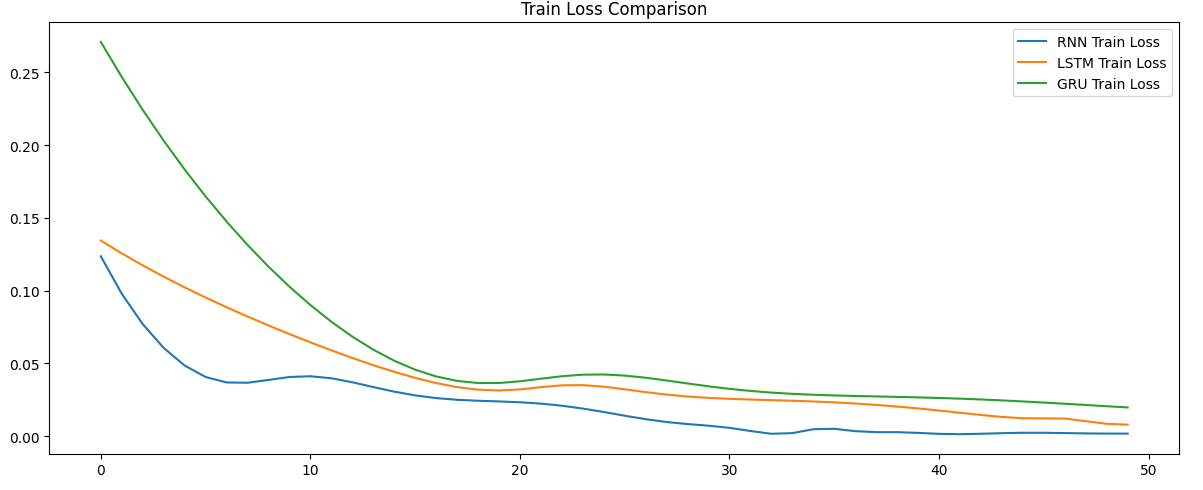

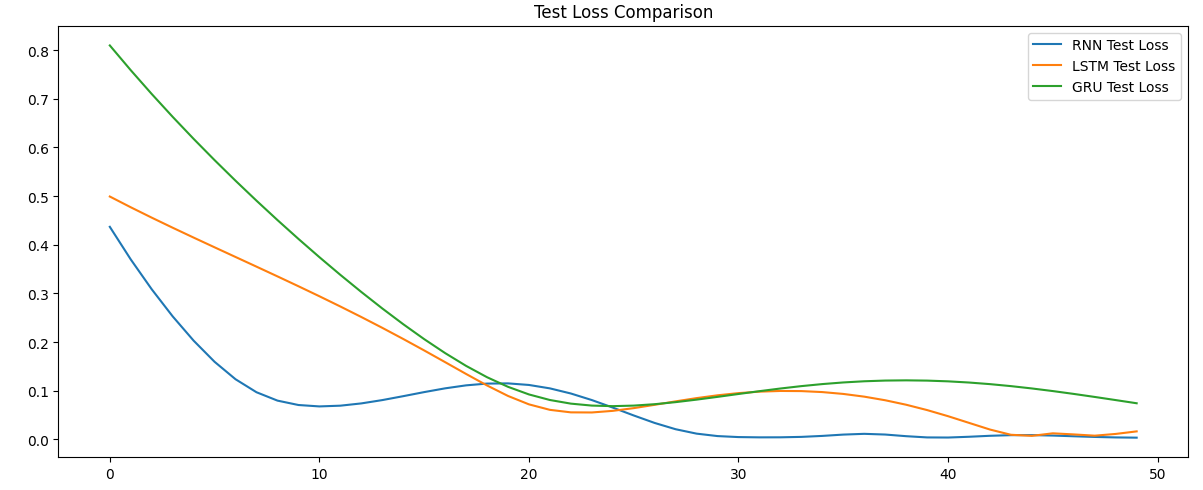

아래는 epoch=100, lr=0.0005로 수정한 결과이다.
RNN, LSTM, GRU의 성능 차이가 줄어들긴 하지만 여전히 RNN의 성능이 가장 좋다.

데이터의 양이 LSTM과 GRU가 가진 복잡한 구조의 파라미터를 충분히 학습할 만큼 충분하지 않으며, RNN에서 장기 의존성 문제가 발생할 정도로 시퀀스 길이가 길지 않기 때문에, RNN만으로도 충분히 학습이 잘 이루어진 것으로 판단된다.




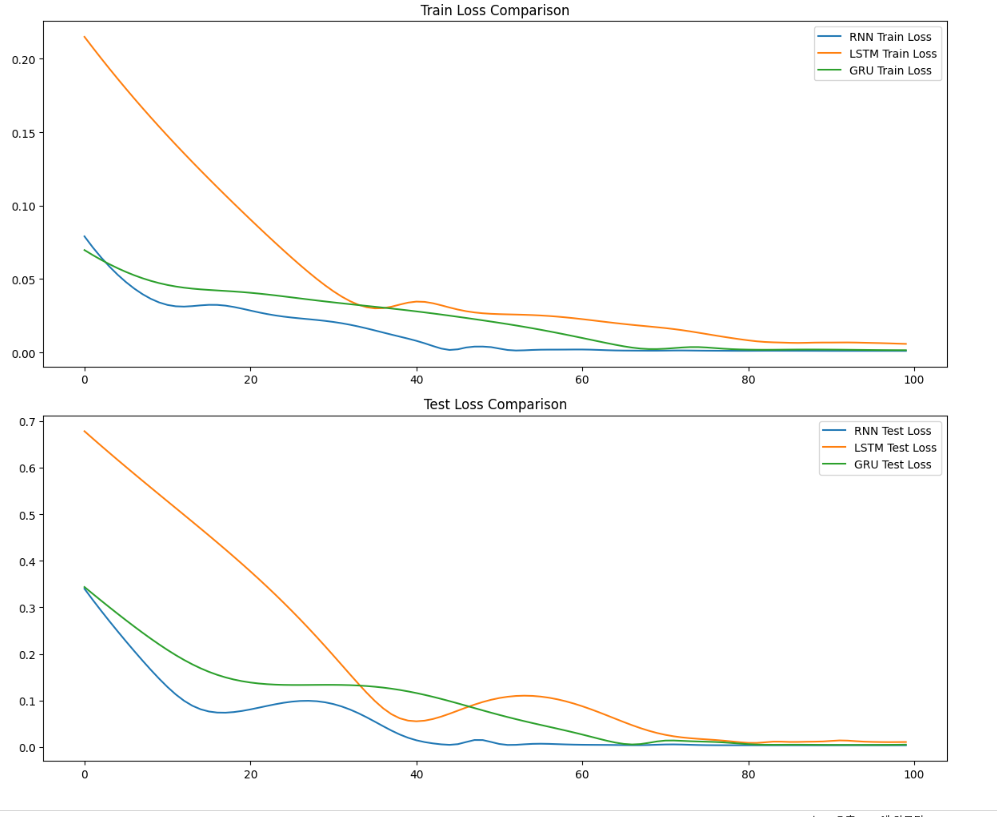